대기시간: 접안(배를 육지에 대는 것)전에 선박이 해상에 정박(해상에 닻을 바다 밑바닥에 내려놓고 운항을 멈추는 것)하는 시간

산출된 항차(선박의 여정)데이터를 활용하여 항만 內 선박의 대기 시간을 예측

# 1. 라이브러리 호출

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

In [ ]:
!pwd

# 2. train, test data load

In [ ]:
train = pd.read_csv('./HD/Data/train.csv')
test = pd.read_csv('./HD/Data/test.csv')

In [ ]:
print(len(train), len(test))

In [ ]:
test.info()

ARI_CO: 도착항의 소속국가(도착항 앞 2글자)
- 'CN', 'JP', 'RU', 'AU', 'SG', 'ZA', 'KR', 'TW', 'TT', 'ID', 'BR', 'QA', 'LV', 'MZ', 'US', 'IN', 'UA', 'CA', 'MY', 'PE', 'VN', 'FI', 'CL', 'VE', 'PH'

ARI_PO: 도착항의 항구명(도착항 뒤 글자)
- 'EKP8', 'EUC8', 'NGG6', 'TMR7', 'NNC2', 'ZAG4', 'MIA8', 'QYY1', 'WHH4', 'YDP4', 'KSF1', 'VYJ1', 'GIW5', 'SPG1', 'CXL1', 'BGD2', 'FCD5', 'QQW1', 'JWI3', 'HGH2', 'IVU2', 'URE2', 'WEY7', 'LXJ7', 'IEW6', 'UVK6', 'MMW5', 'JEN5', 'YRT6', 'VXM8', 'HYG5', 'NCU8', 'JTD1', 'VFD8', 'AZU6', 'AIB7', 'KIU2', 'TDA5', 'WXQ2', 'MCG4', 'QEA4', 'OZD2', 'PDL4', 'UIR7', 'QGN3', 'UJM2', 'TMW2', 'WAF5', 'NQO4', 'CEI5', 'DMD4', 'EVL6', 'XVZ3', 'JER7', 'QTU5', 'XIU1', 'EVX2', 'BAZ5', 'QGL7', 'PPM2', 'RKA2', 'PEL6', 'LHD1', 'URD4', 'TXO3', 'BGX4', 'FFM2', 'YFK5', 'SLZ5', 'QRN3', 'EIA2', 'FAV3', 'OKM4', 'OBZ3', 'CSP6', 'PAF4', 'TBL3', 'JGL5', 'TYY2', 'XGX5', 'UEW5', 'GRQ5', 'HYV6', 'REJ1', 'PUF3', 'SXD2', 'FTQ1', 'PBQ1', 'JDG8', 'MOC5', 'DEJ2', 'XEO4', 'GQJ7', 'EFG4', 'OOV8', 'UPI6', 'JEA6', 'QXE2', 'DIN2', 'ZME5', 'ONW1', 'XZF6', 'RGT8'
       
SHIP_TYPE_CATEGORY: 선종 통합 바탕으로 5대 선종으로 분류
- 'Bulk', 'Container', 'Cargo', 'Tanker'

DIST: 정박지(ber_port)와 접안지 사이의 거리

ATA: anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)

ID: 선박식별 일련번호

BREADTH: 선박의 폭

BUILT: 선박의 연령

DEADWEIGHT: 선박의 재화중량톤수

DEPTH: 선박의 깊이

DRAUGHT: 흘수 높이

GT: 용적톤수(Gross Tonnage)값

LENGTH: 선박의 길이

SHIPMANAGER: 선박 소유주

FLAG: 선박의 국적

U_WIND: 풍향 u벡터

V_WIND: 풍향 v벡터

AIR_TEMPERATURE: 기온

BN: 보퍼트 풍력 계급

ATA_LT: anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)

DUBAI: 해당일의 두바이유 값

BRENT: 해당일의 브렌트유 값

WTI: 해당일의 WTI 값

BDI_ADJ: 조정된 벌크운임지수

PORT_SIZE: 접안지 폴리곤 영역의 크기

#### <span style="color:blue"> target </span>
CI_HOUR: 대기시간

In [ ]:
train.head()

In [8]:
# target column 없음
test.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE
0,TEST_000000,SG,GIW5,Container,1.826589,2020-06-18 11:58,K322654,50.0,18,117000,...,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615
1,TEST_000001,CN,WEY7,Cargo,25.399386,2021-05-26 22:20,E376681,10.0,13,3810,...,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028
2,TEST_000002,CN,NGG6,Container,111.079467,2019-12-16 0:09,F811111,20.0,26,10900,...,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743
3,TEST_000003,CA,FFM2,Bulk,9.175258,2015-11-16 5:30,A737561,30.0,9,55800,...,31500,190.0,MASW32,Panama,NaN,NaN,NaN,NaN,2,0.000182
4,TEST_000004,JP,QYY1,Container,0.000000,2018-10-24 1:11,A827175,30.0,19,39800,...,33000,220.0,SIEL54,Liberia,NaN,NaN,NaN,NaN,10,0.000552


# 3. data pre processing

## 3.1 이상치 처리

In [9]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
#train

## 3.2 불필요한 데이터 삭제

In [ ]:
train['ID']

0         Z618338
1         X886125
2         T674582
3         Y847238
4         A872328
           ...   
391934    Y375615
391935    K635567
391936    J284147
391937    J644215
391938    D123358
Name: ID, Length: 391939, dtype: object

In [ ]:
train.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)
test.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)

In [ ]:
# train.boxplot(column=['BUILT'])
# plt.show()

## 3.3 결측치 처리
mean 대체

In [ ]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
# 선박의 평균 수명이 20~ 25인걸 생각하면 70이 넘는 건 뭘까나
train[train['BUILT'] > 50]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
2970,CA,XIU1,Bulk,2.337824,2018-12-02 1:02,20.0,71,18600,10.0,10.0,...,190.0,JXIH61,Canada,-0.29491,-0.263849,18.862968,2.706992,21,0.000036,36.436111
4218,CA,PUF3,Bulk,3.546383,2020-06-16 0:12,20.0,56,30700,10.0,10.0,...,220.0,PLXS34,Canada,2.66000,0.310000,16.200000,2.173051,21,0.000107,54.231111
6150,CA,XIU1,Bulk,5.078250,2022-09-28 19:31,20.0,56,28500,10.0,10.0,...,220.0,PLXS34,Canada,3.40000,-3.260000,7.800000,3.166401,17,0.000036,19.161944
12990,CA,XIU1,Bulk,4.436569,2017-10-03 14:18,20.0,56,28500,10.0,10.0,...,220.0,PLXS34,Canada,-0.29491,-0.263849,18.862968,2.706992,11,0.000036,28.563056
15452,UA,PEL6,Cargo,3.252657,2021-09-27 21:55,10.0,65,1600,0.0,0.0,...,100.0,KOLZ83,Ukraine,-1.59000,-3.170000,8.900000,2.620524,0,0.000117,7.763333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365516,CA,XIU1,Bulk,28.683901,2019-06-04 14:56,20.0,56,28500,10.0,10.0,...,220.0,PLXS34,Canada,0.00000,0.000000,9.700000,0.000000,12,0.000036,9.582222
368667,CA,XIU1,Bulk,2.193202,2020-12-08 22:40,20.0,56,28500,10.0,10.0,...,220.0,PLXS34,Canada,1.37000,-2.020000,-7.300000,2.042736,19,0.000036,3.903056
373091,CA,PUF3,Bulk,0.000000,2017-07-11 23:22,20.0,80,15800,10.0,10.0,...,190.0,JXIH61,Canada,-0.29491,-0.263849,18.862968,2.706992,20,0.000107,0.000000
375480,CN,NGG6,Container,1.140698,2018-06-26 15:28,30.0,52,38700,20.0,10.0,...,240.0,CRYG56,United States Of America,-0.29491,-0.263849,18.862968,2.706992,23,0.001743,1.794444


## 3.4 데이터 변환

In [ ]:
#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

In [ ]:
train.head()

,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,ARI_COPO
0,Container,30.881018,2018-12-17 21:29,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,-0.29491,-0.263849,18.862968,2.706992,5,0.002615,3.450000,SG_GIW5
1,Bulk,0.000000,2014-09-23 6:59,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,-0.29491,-0.263849,18.862968,2.706992,12,0.000217,0.000000,IN_UJM2
2,Container,0.000000,2015-02-03 22:00,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,Malta,-0.29491,-0.263849,18.862968,2.706992,6,0.001614,0.000000,CN_EUC8
3,Container,0.000000,2020-01-17 4:02,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18000,-1.610000,6.700000,2.629350,13,0.000356,0.000000,JP_ZAG4
4,Container,27.037650,2020-01-26 7:51,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33000,-3.280000,25.600000,2.495953,15,0.002615,253.554444,SG_GIW5


In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday # 요일(0-월, 1-화)

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [ ]:
train.head()

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,ATA_LT,PORT_SIZE,CI_HOUR,ARI_COPO,year,month,day,hour,minute,weekday
0,Container,30.881018,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,...,5,0.002615,3.450000,SG_GIW5,2018,12,17,21,29,0
1,Bulk,0.000000,30.0,13,35900,10.0,10.0,23500,180.0,SPNO34,...,12,0.000217,0.000000,IN_UJM2,2014,9,23,6,59,1
2,Container,0.000000,50.0,12,146000,30.0,20.0,140000,370.0,FNPK22,...,6,0.001614,0.000000,CN_EUC8,2015,2,3,22,0,1
3,Container,0.000000,20.0,18,6910,10.0,10.0,5400,120.0,PBZV77,...,13,0.000356,0.000000,JP_ZAG4,2020,1,17,4,2,4
4,Container,27.037650,50.0,10,116000,20.0,10.0,96600,300.0,GUCE76,...,15,0.002615,253.554444,SG_GIW5,2020,1,26,7,51,6


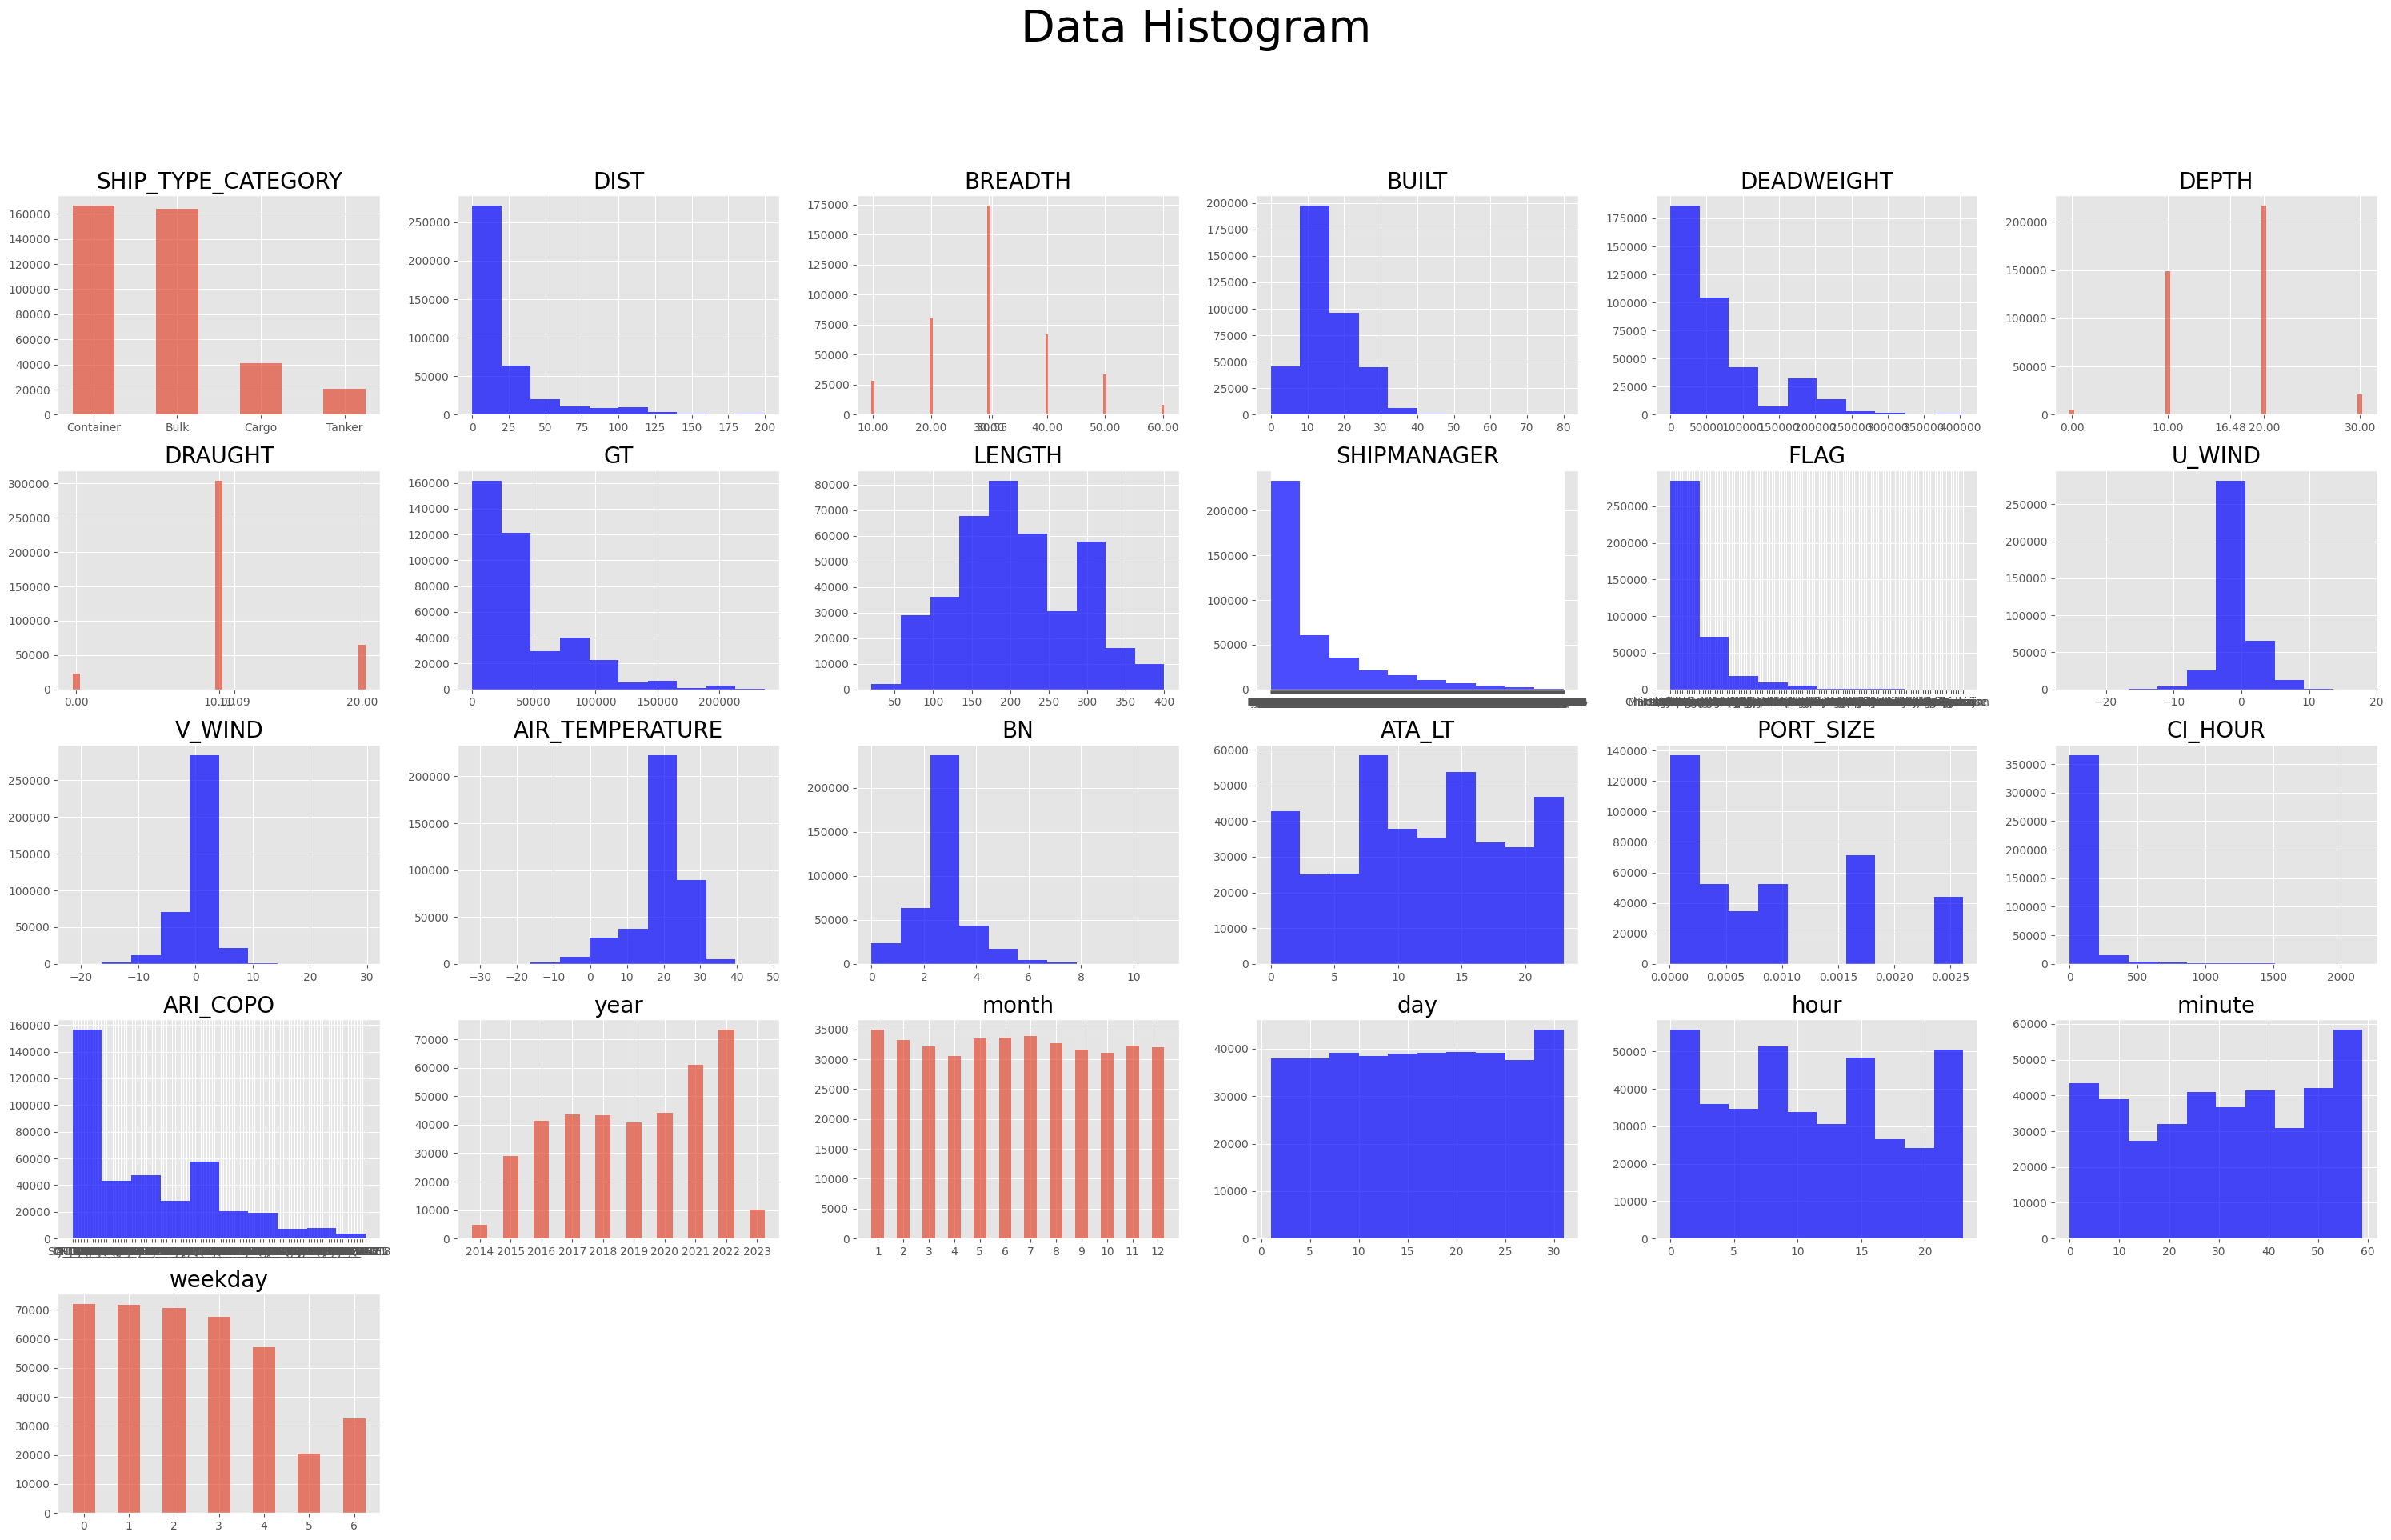

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(30, 40))
plt.suptitle("Data Histogram", fontsize=40)

cols = train.columns
num_cols = len(cols)
rows = num_cols // 6 + (num_cols % 6 > 0)

for i in range(num_cols):
    plt.subplot(rows, 6, i+1)
    plt.title(cols[i], fontsize=20)
    if len(train[cols[i]].unique()) > 20:
        plt.hist(train[cols[i]], color='b', alpha=0.7)
    else:
        temp = train[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())

plt.tight_layout(rect=[0, 0.5, 1, 0.95])
plt.show()


## 3.5 데이터 전처리

### 시간 데이터 변환

In [ ]:
# hour에 대한  cos 변환
train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)
# month에 대한  cos 변환
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
# day에 대한  cos 변환 (day는 월의 일 수에 따라 다르므로 가장 흔한 30일로 나눕니다.)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 30)
# weekday에 대한  cos 변환
train['weekday_cos'] = np.cos(2 * np.pi * train['weekday'] / 7)
# minute에 대한  cos 변환
train['minute_cos'] = np.cos(2 * np.pi * train['minute'] / 60)
# 연도 데이터에 코사인 변환 적용
train['year_cos'] = np.cos(2 * np.pi * train['year'] / max(train['year']))  # 연도의 최대값으로 나누어 정규화

# hour에 대한  cos 변환
test['hour_cos'] = np.cos(2 * np.pi * test['hour'] / 24)
# month에 대한  cos 변환
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
# day에 대한  cos 변환 (day는 월의 일 수에 따라 다르므로 가장 흔한 30일로 나눕니다.)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 30)
# weekday에 대한  cos 변환
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
# minute에 대한  cos 변환
test['minute_cos'] = np.cos(2 * np.pi * test['minute'] / 60)
# 연도 데이터에 코사인 변환 적용
test['year_cos'] = np.cos(2 * np.pi * test['year'] / max(test['year']))  # 연도의 최대값으로 나누어 정규화


hours_col = ['hour','day','month','minute','weekday','year']
train = train.drop(hours_col, axis=1)
test = test.drop(hours_col, axis=1)

In [ ]:
!pip install tqdm

### Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import bisect

categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY',  'SHIPMANAGER', 'FLAG']
encoders = {}


for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    encoders[feature] = le

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    test[feature] = le.fit_transform(test[feature].astype(str))
    encoders[feature] = le

train.head()

Encoding features: 100%|██████████| 4/4 [00:00<00:00, 14.68it/s]


,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,ATA_LT,PORT_SIZE,CI_HOUR,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,2,30.881018,30.0,24,24300,10.0,10.0,16700,180.0,686,...,5,0.002615,3.450000,90,7.071068e-01,1.000000e+00,-0.913545,1.000000,-0.994522,0.999879
1,0,0.000000,30.0,13,35900,10.0,10.0,23500,180.0,4720,...,12,0.000217,0.000000,52,6.123234e-17,-1.836970e-16,0.104528,0.623490,0.994522,0.999609
2,2,0.000000,50.0,12,146000,30.0,20.0,140000,370.0,1370,...,6,0.001614,0.000000,23,8.660254e-01,5.000000e-01,0.809017,0.623490,1.000000,0.999691
3,2,0.000000,20.0,18,6910,10.0,10.0,5400,120.0,3809,...,13,0.000356,0.000000,66,5.000000e-01,8.660254e-01,-0.913545,-0.900969,0.978148,0.999957
4,2,27.037650,50.0,10,116000,20.0,10.0,96600,300.0,1687,...,15,0.002615,253.554444,90,-2.588190e-01,8.660254e-01,0.669131,0.623490,0.587785,0.999957


In [ ]:
test.head()

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,BN,ATA_LT,PORT_SIZE,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,2,1.826589,50.0,18,117000,30.0,20.0,109000,340.0,2482,...,1.587063,19,0.002615,90,-0.965926,-1.000000,-0.809017,-0.900969,0.978148,0.999957
1,1,25.399386,10.0,13,3810,10.0,10.0,2560,80.0,2591,...,2.663972,6,0.001028,37,0.866025,-0.866025,0.669131,-0.222521,-0.500000,0.999981
2,2,111.079467,20.0,26,10900,10.0,10.0,8440,140.0,1032,...,3.255315,8,0.001743,29,1.000000,1.000000,-0.978148,1.000000,0.587785,0.999923
3,0,9.175258,30.0,9,55800,20.0,10.0,31500,190.0,2831,...,2.709961,2,0.000182,15,0.258819,0.866025,-0.978148,1.000000,-1.000000,0.999691
4,2,0.000000,30.0,19,39800,20.0,10.0,33000,220.0,4306,...,2.709961,10,0.000552,61,0.965926,0.500000,0.309017,-0.222521,0.406737,0.999879


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer

def quantileTransform(data) :
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['DEADWEIGHT', 'GT', 'DIST', 'BN']
right_skewed_cols = ['AIR_TEMPERATURE']

#print(len(left_skewed_cols))
#print(len(right_skewed_cols))

# train_scaler
train[left_skewed_cols] = logTransform(train[left_skewed_cols])
train[right_skewed_cols] = quantileTransform(train[right_skewed_cols])
# test_scaler
test[left_skewed_cols] = logTransform(test[left_skewed_cols])
test[right_skewed_cols] = quantileTransform(test[right_skewed_cols])
train

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,ATA_LT,PORT_SIZE,CI_HOUR,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,2,1.495600,30.0,24,2.406789,10.0,10.0,2.372412,180.0,686,...,5,0.002615,3.450000,90,7.071068e-01,1.000000e+00,-0.913545,1.000000,-9.945219e-01,0.999879
1,0,0.000000,30.0,13,2.441348,10.0,10.0,2.403769,180.0,4720,...,12,0.000217,0.000000,52,6.123234e-17,-1.836970e-16,0.104528,0.623490,9.945219e-01,0.999609
2,2,0.000000,50.0,12,2.556558,30.0,20.0,2.553297,370.0,1370,...,6,0.001614,0.000000,23,8.660254e-01,5.000000e-01,0.809017,0.623490,1.000000e+00,0.999691
3,2,0.000000,20.0,18,2.286544,10.0,10.0,2.261173,120.0,3809,...,13,0.000356,0.000000,66,5.000000e-01,8.660254e-01,-0.913545,-0.900969,9.781476e-01,0.999957
4,2,1.466387,50.0,10,2.538554,20.0,10.0,2.523995,300.0,1687,...,15,0.002615,253.554444,90,-2.588190e-01,8.660254e-01,0.669131,0.623490,5.877853e-01,0.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,20.0,27,2.285211,10.0,10.0,2.249262,110.0,2562,...,14,0.000552,0.000000,61,2.588190e-01,-1.000000e+00,0.309017,0.623490,9.781476e-01,0.999826
391935,0,1.074759,10.0,12,2.203719,10.0,10.0,2.125655,80.0,2400,...,8,0.002615,144.061389,90,1.000000e+00,5.000000e-01,-0.978148,-0.222521,-8.090170e-01,0.999923
391936,0,1.662398,30.0,8,2.485498,20.0,10.0,2.438636,200.0,6106,...,18,0.000155,41.482222,97,8.660254e-01,6.123234e-17,0.104528,0.623490,-8.660254e-01,0.999981
391937,2,1.207893,30.0,29,2.404914,10.0,10.0,2.373521,170.0,1771,...,15,0.000990,7.485278,93,-2.588190e-01,8.660254e-01,-0.104528,-0.900969,2.832769e-16,0.999691


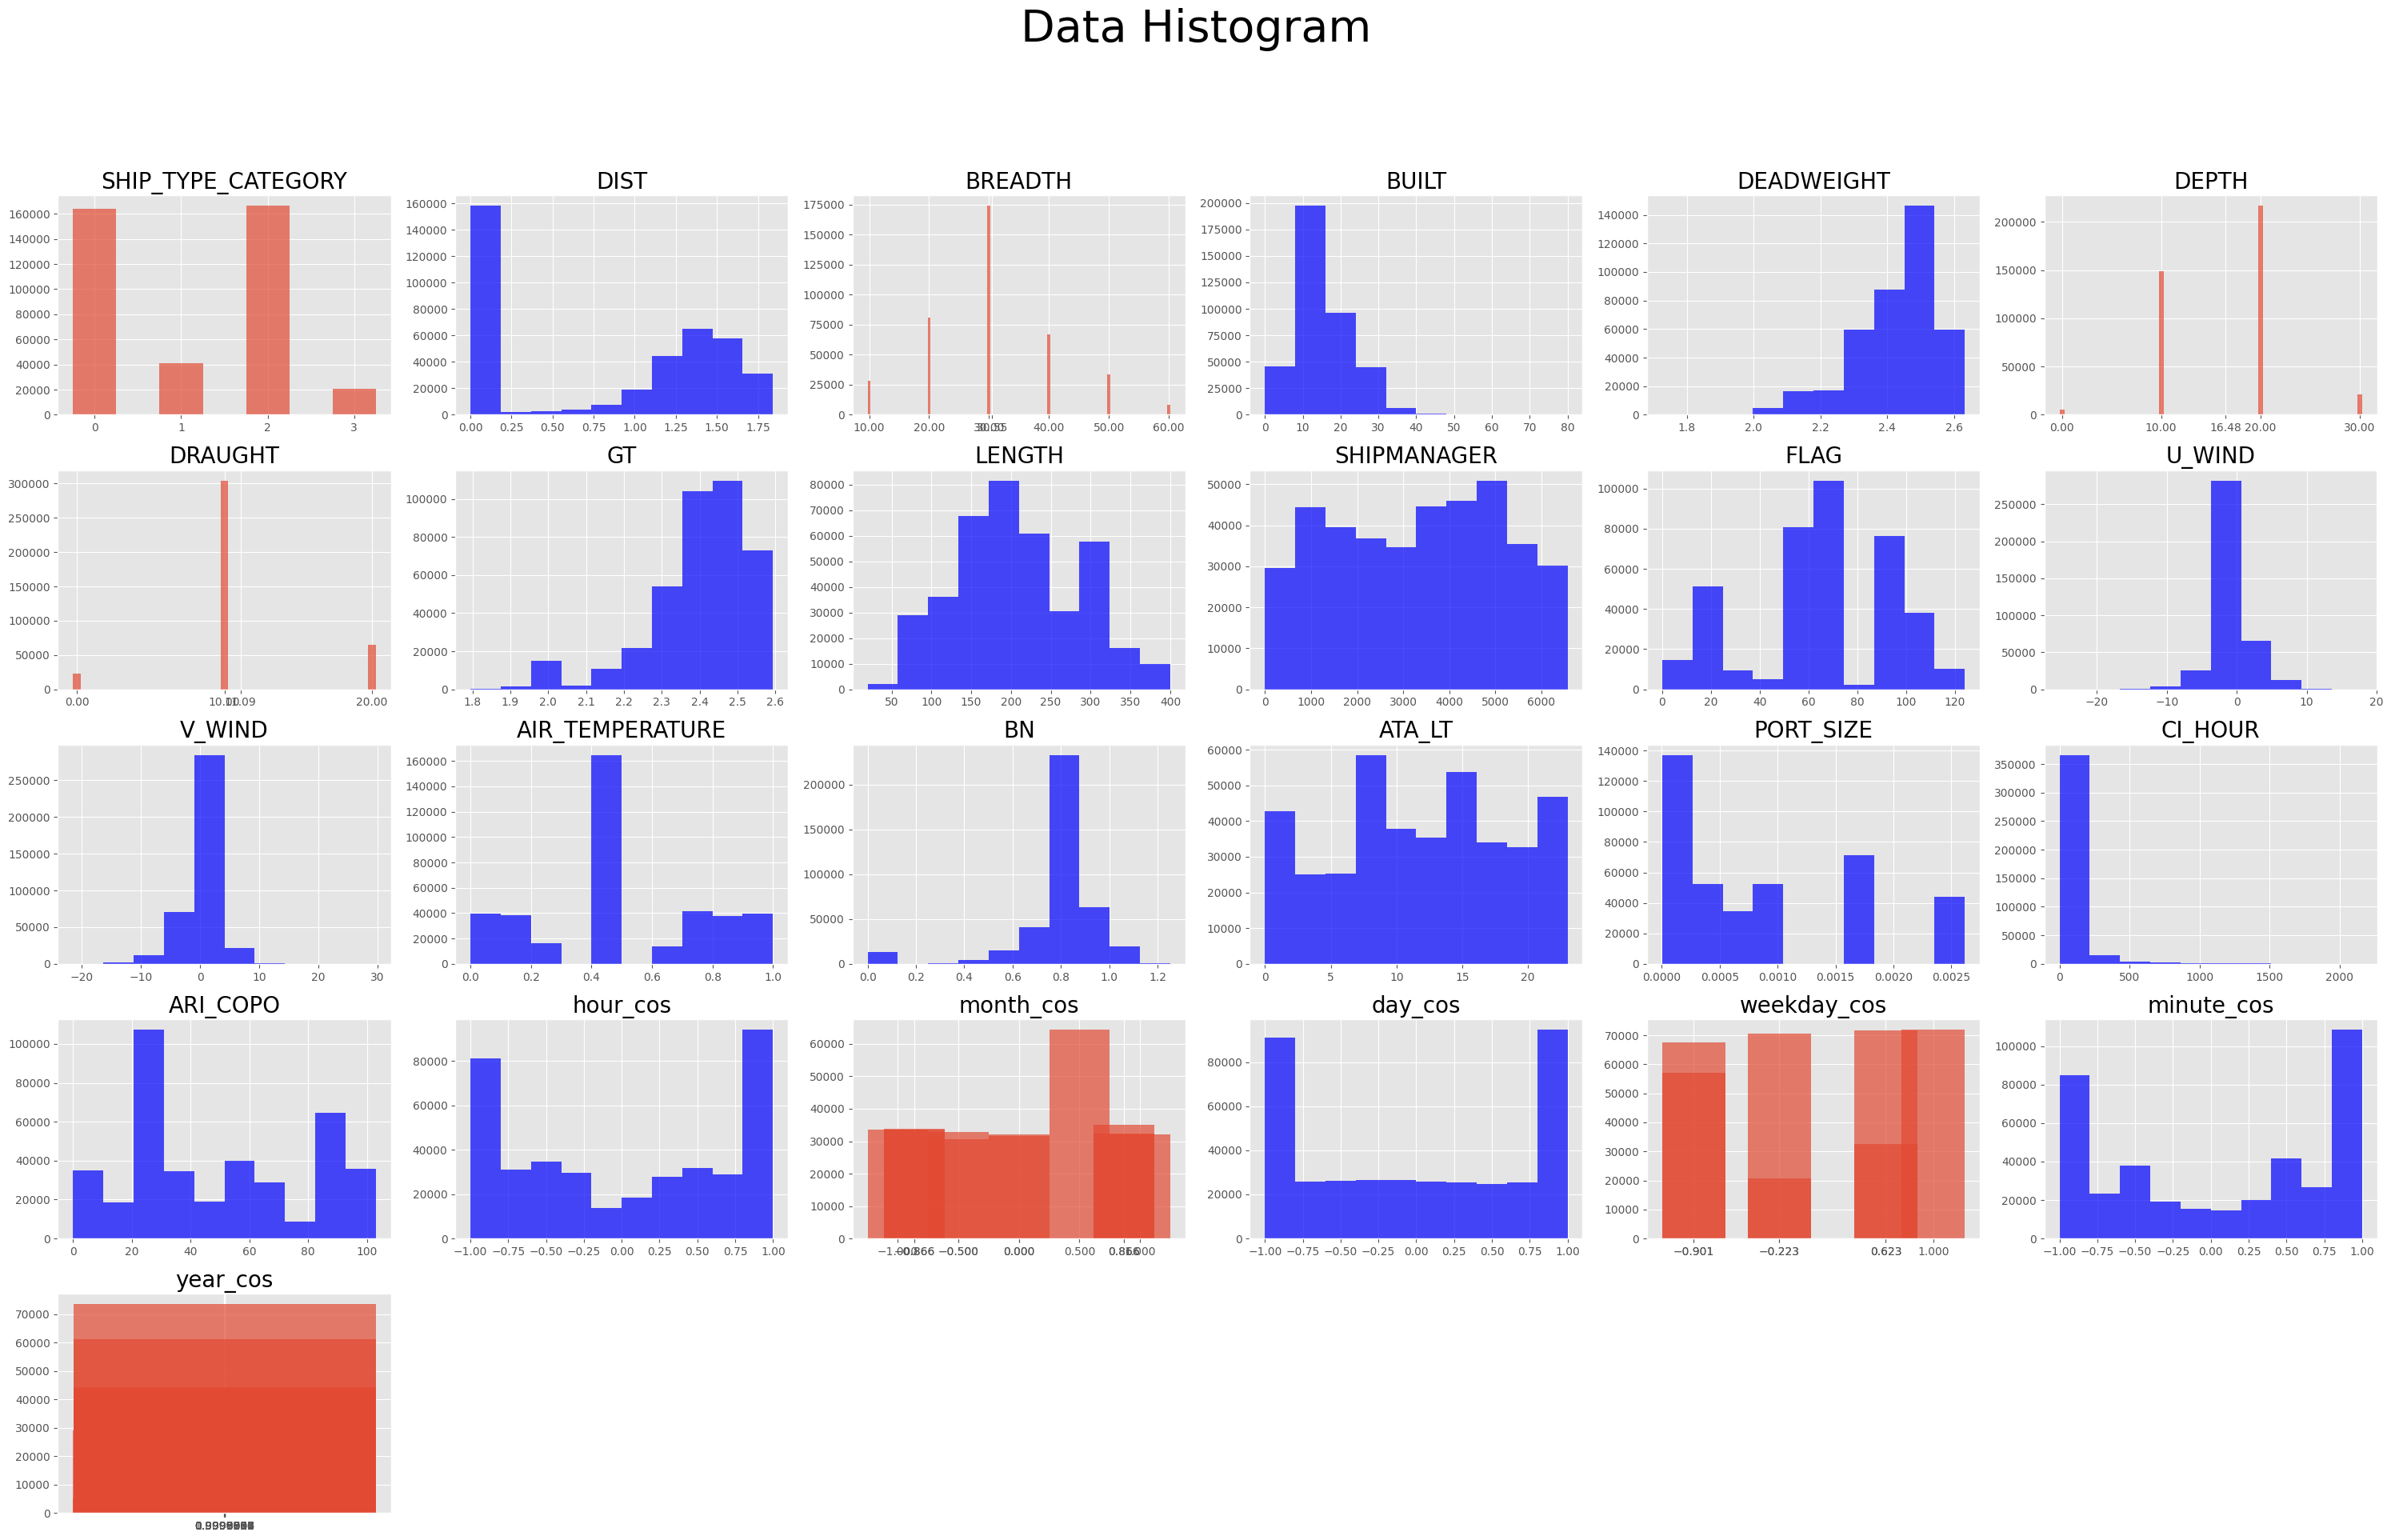

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(30, 40))
plt.suptitle("Data Histogram", fontsize=40)

cols = train.columns
num_cols = len(cols)
rows = num_cols // 6 + (num_cols % 6 > 0)

for i in range(num_cols):
    plt.subplot(rows, 6, i+1)
    plt.title(cols[i], fontsize=20)
    if len(train[cols[i]].unique()) > 20:
        plt.hist(train[cols[i]], color='b', alpha=0.7)
    else:
        temp = train[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())

plt.tight_layout(rect=[0, 0.5, 1, 0.95])
plt.show()


In [ ]:
train.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'CI_HOUR', 'ARI_COPO', 'hour_cos', 'month_cos', 'day_cos',
       'weekday_cos', 'minute_cos', 'year_cos'],
      dtype='object')

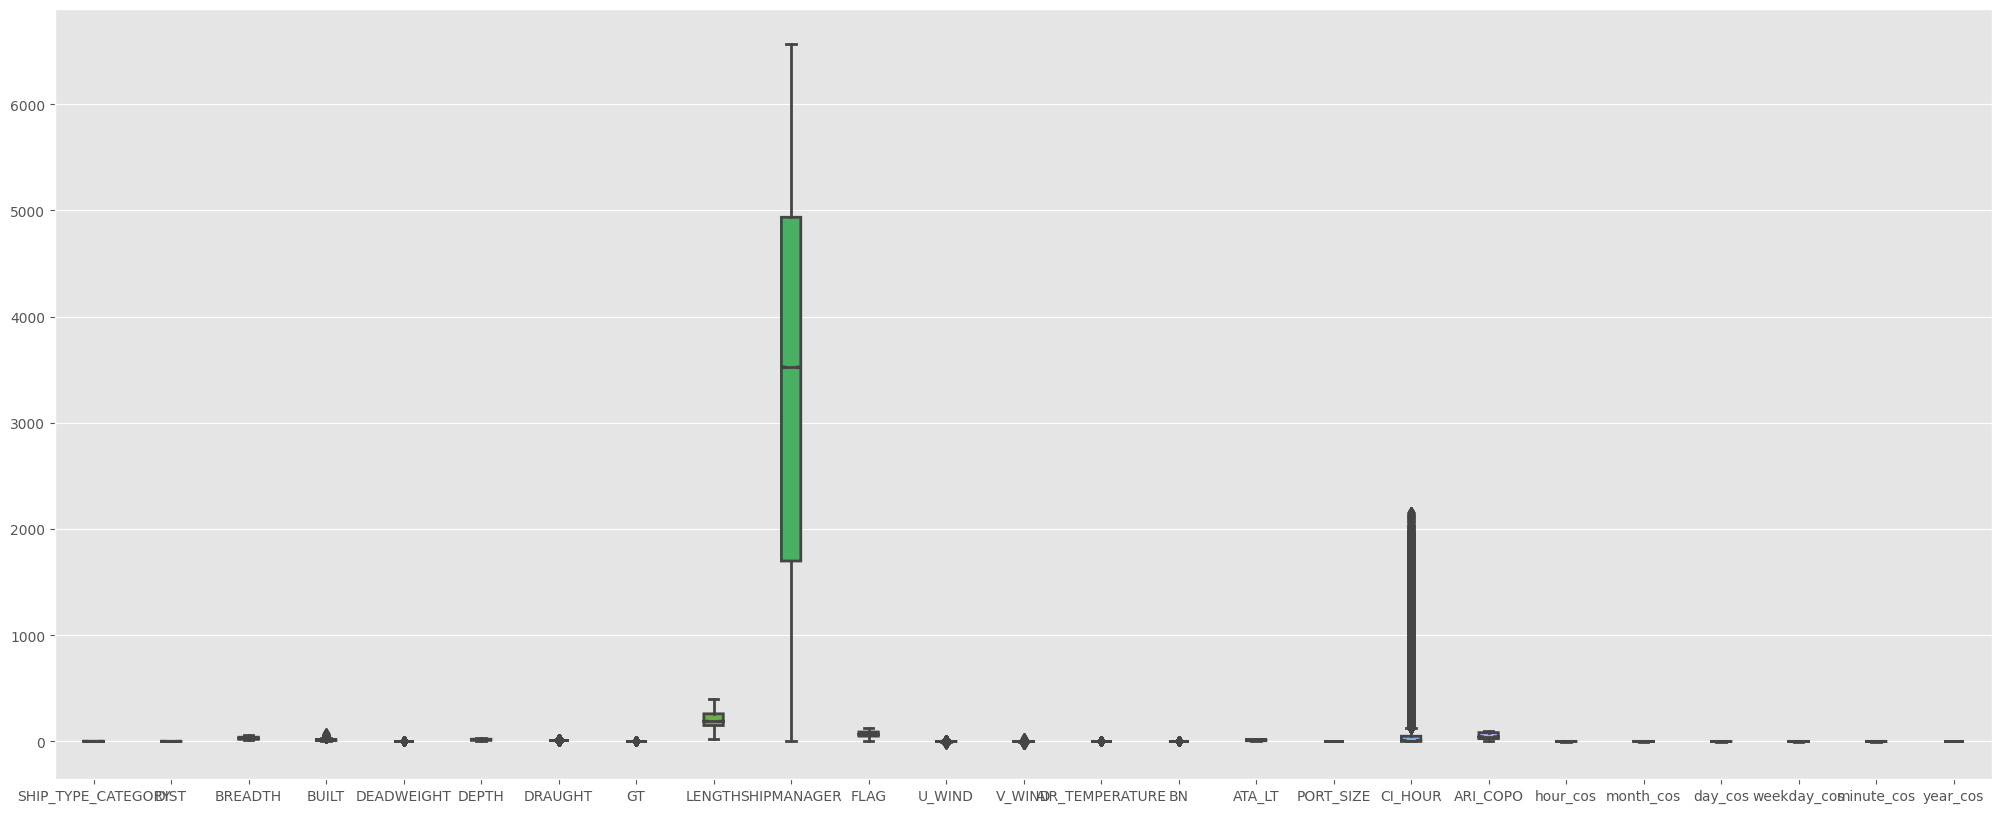

In [ ]:
#이상치 값이 있는지 확인
import seaborn as sns

name_list = ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT','PORT_SIZE', 'CI_HOUR',
        'ARI_COPO', 'hour_cos', 'month_cos', 'day_cos',
       'weekday_cos', 'minute_cos', 'year_cos']
na_list = train.loc[:, name_list]
plt.figure(figsize=(25,10))
sns.boxplot(data = na_list,notch = True, linewidth = 2, width = 0.25)

scaled_data = train.copy()
scaled_test = test.copy()

In [ ]:
scaled_data

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,BDI_ADJ,PORT_SIZE,CI_HOUR,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,0,3.457470,30.0,28,11.199597,20.0,10.0,10.561033,220.0,591,...,7.250400,0.001660,3.048333,22,5.000000e-01,5.000000e-01,-1.000000,-0.900969,0.951057,0.999957
1,2,4.162321,30.0,15,10.542733,20.0,10.0,10.243560,220.0,723,...,7.644942,0.001614,17.138611,23,8.660254e-01,-1.836970e-16,-0.913545,0.623490,0.866025,0.999923
2,2,4.515545,50.0,7,11.652696,20.0,10.0,11.476272,300.0,2199,...,6.403894,0.001743,98.827500,29,6.123234e-17,5.000000e-01,0.104528,-0.222521,-0.207912,0.999923
3,1,0.000000,10.0,33,7.307202,10.0,0.0,6.552508,70.0,3226,...,7.065488,0.000069,0.000000,63,8.660254e-01,-1.836970e-16,-0.809017,-0.900969,0.809017,0.999957
4,2,2.283782,30.0,10,10.225607,10.0,10.0,9.867912,180.0,3723,...,7.011164,0.000197,96.030556,85,-1.000000e+00,-5.000000e-01,-0.913545,-0.222521,0.951057,0.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,0,4.094648,40.0,13,11.442514,20.0,10.0,10.845466,230.0,933,...,7.196394,0.000360,65.850000,39,8.660254e-01,8.660254e-01,-0.669131,-0.222521,-0.743145,0.999826
367437,3,0.000000,10.0,9,7.155396,0.0,0.0,6.216606,60.0,3769,...,7.578710,0.000552,0.000000,61,8.660254e-01,-5.000000e-01,0.978148,-0.900969,0.978148,0.999995
367438,2,1.018353,30.0,6,10.126671,20.0,10.0,10.130663,180.0,2396,...,7.379190,0.002615,0.997500,90,-2.588190e-01,-8.660254e-01,-0.978148,-0.900969,0.978148,0.999995
367439,1,0.000000,10.0,8,7.783641,10.0,0.0,6.621406,80.0,5069,...,7.083684,0.000069,0.000000,63,-8.660254e-01,1.000000e+00,-0.104528,0.623490,0.743145,0.999957


In [ ]:
scaled_test

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,WTI,BDI_ADJ,PORT_SIZE,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,3,2.352150,20.0,9,8.614501,10.0,10.0,8.221748,100.0,5278,...,0.871872,6.643761,0.000256,54,-0.500000,-5.000000e-01,0.809017,-0.222521,-0.994522,0.999995
1,2,3.226315,40.0,14,11.599112,20.0,10.0,11.455307,330.0,3189,...,0.926927,7.412164,0.002615,90,0.500000,6.123234e-17,0.809017,0.623490,0.951057,0.999995
2,1,0.000000,20.0,14,9.525224,10.0,10.0,9.097284,140.0,4985,...,0.803804,6.527366,0.000427,92,0.866025,8.660254e-01,-0.809017,-0.222521,0.809017,1.000000
3,0,0.000000,10.0,18,7.951911,10.0,10.0,7.586296,80.0,5367,...,0.074432,6.446320,0.000256,54,1.000000,-5.000000e-01,0.913545,0.623490,0.994522,0.999764
4,2,3.036595,30.0,23,10.332051,20.0,10.0,10.165890,200.0,1078,...,0.812646,6.335235,0.002615,90,1.000000,8.660254e-01,0.309017,0.623490,-0.951057,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244984,0,0.965347,10.0,35,8.045909,10.0,0.0,7.576097,90.0,1451,...,0.632633,7.270024,0.000011,89,0.866025,5.000000e-01,-0.104528,1.000000,0.406737,0.999879
244985,0,3.454512,30.0,17,10.745076,20.0,10.0,10.146473,180.0,4963,...,0.488488,7.128123,0.000011,89,0.500000,-1.000000e+00,-0.104528,-0.222521,1.000000,0.999923
244986,1,0.000000,20.0,12,8.571871,10.0,10.0,8.006701,90.0,2895,...,0.310310,7.150861,0.000026,31,-0.965926,6.123234e-17,1.000000,-0.900969,-0.913545,0.999826
244987,2,0.000000,20.0,27,8.856661,10.0,10.0,8.499233,110.0,3190,...,0.887888,7.143866,0.000006,101,-0.258819,-5.000000e-01,-0.500000,-0.222521,-0.500000,0.999995


In [ ]:
# # 수치형 변수
# #minmax? standard?
# from sklearn.preprocessing import RobustScaler
# s_columns = ['BREADTH', 'BUILT', 'DEPTH','DRAUGHT', 'LENGTH', 'U_WIND', 'V_WIND','ATA_LT', 'BRENT','PORT_SIZE',]
# standardScaler = MinMaxScaler()

# for col in s_columns:
#     scaled_data[col] = standardScaler.fit_transform(scaled_data[col].values.reshape(-1, 1))
#     scaled_test[col] = standardScaler.fit_transform(scaled_test[col].values.reshape(-1, 1))
# # scaled_data_1 = pd.DataFrame(standardScaler.fit_transform(scaled_data[s_columns]), columns = s_columns)
# # scaled_test_1 = pd.DataFrame(standardScaler.fit_transform(scaled_test), columns = scaled_test.columns)
# # scaled_test.iloc[:, :48] = scaled_data_1
# # scaled_data.iloc[:, :48] = scaled_test_1

# scaled_data

KeyError: ignored

In [ ]:
# 결측치 확인
# print(train.isnull().sum())
# print('\n')
# print(test.isnull().sum())
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  391939 non-null  int64  
 1   DIST                391939 non-null  float64
 2   BREADTH             391939 non-null  float64
 3   BUILT               391939 non-null  float64
 4   DEADWEIGHT          391939 non-null  float64
 5   DEPTH               391939 non-null  float64
 6   DRAUGHT             391939 non-null  float64
 7   GT                  391939 non-null  float64
 8   LENGTH              391939 non-null  float64
 9   SHIPMANAGER         391939 non-null  int64  
 10  FLAG                391939 non-null  int64  
 11  U_WIND              391939 non-null  float64
 12  V_WIND              391939 non-null  float64
 13  AIR_TEMPERATURE     391939 non-null  float64
 14  BN                  391939 non-null  float64
 15  ATA_LT              391939 non-nul

<Axes: >

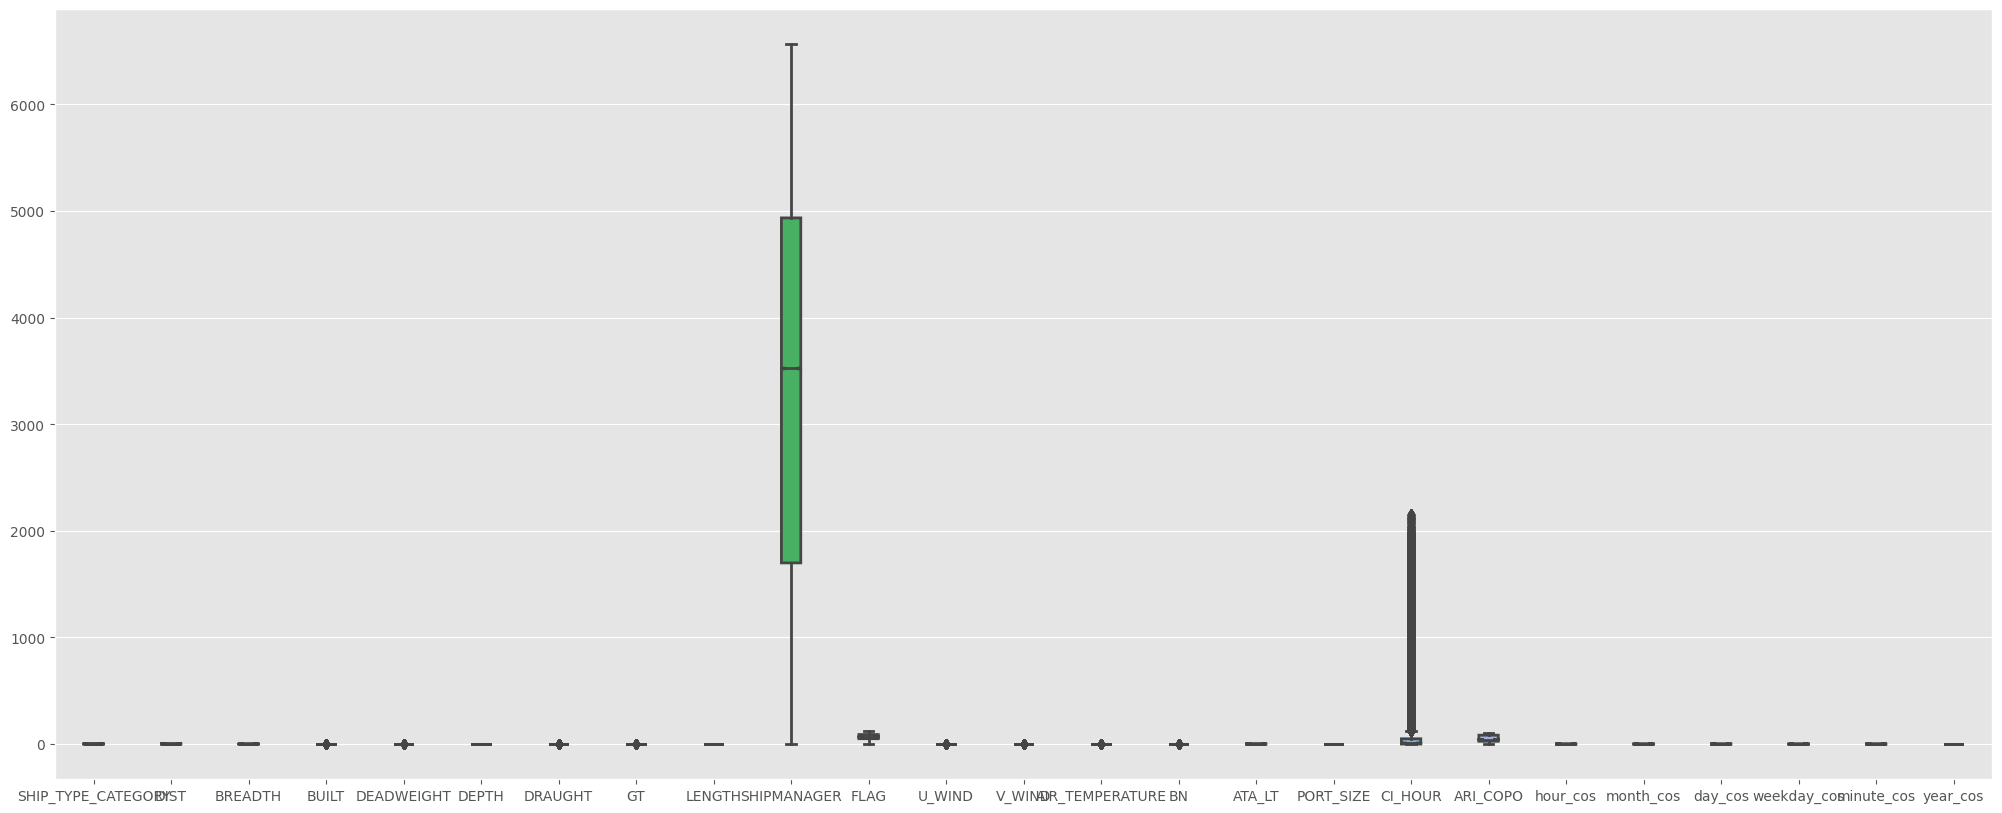

In [ ]:
#이상치 값이 있는지 확인
import seaborn as sns

name_list = ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT','PORT_SIZE', 'CI_HOUR', 'ARI_COPO',
       'hour_cos', 'month_cos', 'day_cos','weekday_cos', 'minute_cos', 'year_cos']
na_list = scaled_data.loc[:, name_list]
plt.figure(figsize=(25,10))
sns.boxplot(data = na_list,notch = True, linewidth = 2, width = 0.25)

In [ ]:
scaled_test.info()

#### 3.1 csv 파일로 저장

In [ ]:
scaled_data.to_csv('./HD/Data/scalied_train.csv', index=False, encoding='utf-8')
scaled_test.to_csv('./HD/Data/scalied_test.csv', index=False, encoding='utf-8')

# 4. 모델 학습 및 특성 중요도 확인

In [ ]:
# 함수 정의
def train_and_evaluate(model, model_name, X_train, y_train):
    model.fit(X_train, y_train)

    # 변수 중요도
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort() # index

    plt.figure(figsize=(10, len(X_train.columns)/2))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = scaled_data.drop(columns='CI_HOUR')
y_train = scaled_data['CI_HOUR']
X_test = scaled_test

##4.  1 변수 전처리만 진행하고 학습

In [ ]:
ada = RandomForestRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    ada.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = ada.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    ada_pred = ada.predict(X_test)
    ada_pred = np.where(ada_pred < 0, 0, ada_pred)

    ensemble_predictions.append(ada_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

In [ ]:
print(final_predictions)

## 4. 2 변수 중요도로 나눠서 학습

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 24
[LightGBM] [Info] Start training from score 61.933506


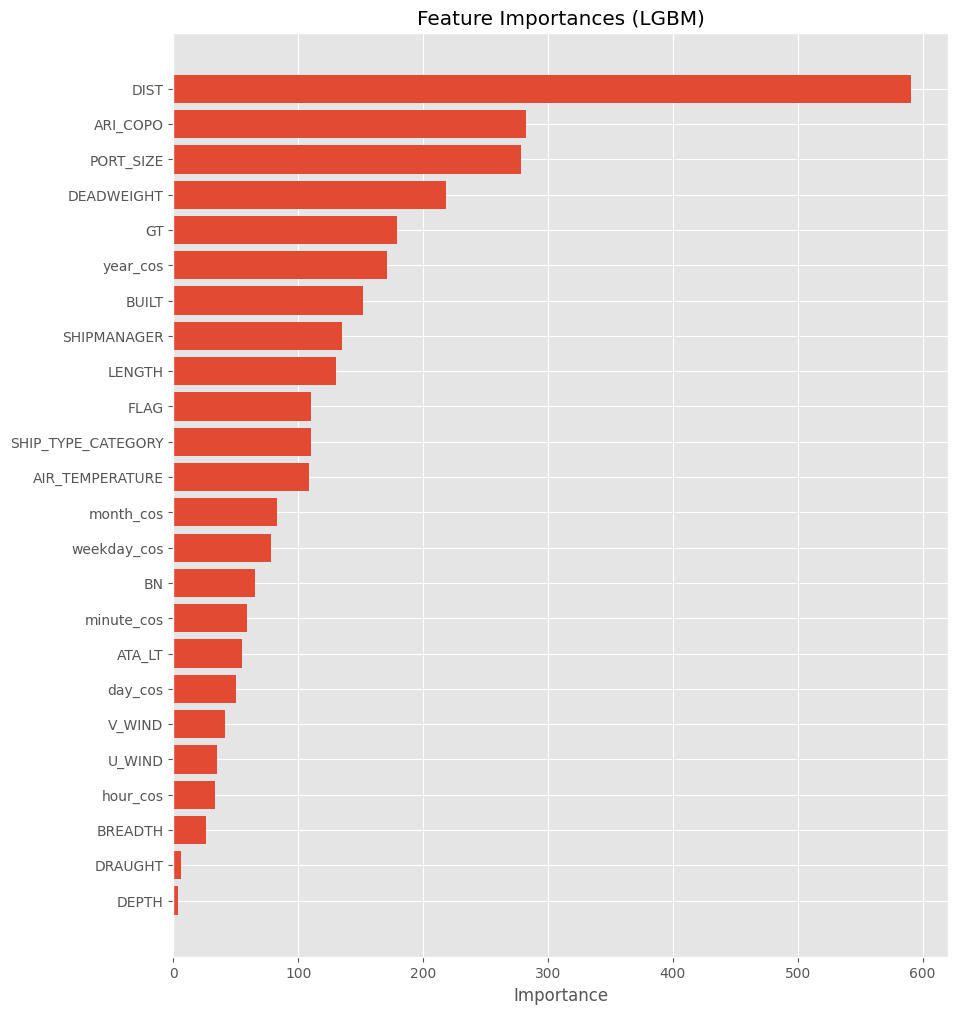

In [ ]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [ ]:
X_train.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ARI_COPO', 'hour_cos',
       'month_cos', 'day_cos', 'weekday_cos', 'minute_cos', 'year_cos'],
      dtype='object')

In [ ]:
lgbm_feature_importances

array([110, 591,  26, 152, 218,   4,   6, 179, 130, 135, 110,  35,  41,
       109,  65,  55, 278, 282,  33,  83,  50,  78,  59, 171], dtype=int32)

#### LGBM 으로 변수 중요도를 뽑고 각 변수들을 PCA로 압축

In [ ]:
import pandas as pd

# 가상의 특성 중요도 데이터프레임 생성
feature_importance = pd.DataFrame({
    'name_list': ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ARI_COPO', 'hour_cos',
       'month_cos', 'day_cos', 'weekday_cos', 'minute_cos', 'year_cos'],
    'Importance': [110, 591,  26, 152, 218,   4,   6, 179, 130, 135, 110,  35,  41,
       109,  65,  55, 278, 282,  33,  83,  50,  78,  59, 171]
})

# 원하는 그룹 수 설정
num_groups = 4

# 중요도 값에 따라 특성 정렬
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 그룹별로 특성을 나누기 위한 그룹 크기 계산
group_size = len(feature_importance) // num_groups

# 그룹별로 특성 나누기
feature_groups = []
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = feature_importance.iloc[start_idx:end_idx]['name_list'].tolist()  # 'name_list'로 수정
    feature_groups.append(group)

# 결과 출력
for i, group in enumerate(feature_groups):
    print(f'Group {i + 1}: {group}')


Group 1: ['DIST', 'ARI_COPO', 'PORT_SIZE', 'DEADWEIGHT', 'GT', 'year_cos']
Group 2: ['BUILT', 'SHIPMANAGER', 'LENGTH', 'FLAG', 'SHIP_TYPE_CATEGORY', 'AIR_TEMPERATURE']
Group 3: ['month_cos', 'weekday_cos', 'BN', 'minute_cos', 'ATA_LT', 'day_cos']
Group 4: ['V_WIND', 'U_WIND', 'hour_cos', 'BREADTH', 'DRAUGHT', 'DEPTH']


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# groups = [feature_groups[0], feature_groups[1], feature_groups[2], feature_groups[3]]
groups = [feature_groups[0], feature_groups[1]]

pca_data1 = []
pca_test1 = []
# X_train = scaled_data.drop(columns='CI_HOUR')
# y_train = scaled_data['CI_HOUR']
# X_test = scaled_test


for group in groups:
    # 데이터 선택
    selected_data_X = X_train[group]

    # PCA
    pca = PCA(n_components=1)
    selected_data_X_pca = pca.fit_transform(selected_data_X)

    # PCA 적용 후 데이터를 리스트에 추가
    pca_data1.append(selected_data_X_pca)

    selected_test_X = X_test[group]

    # PCA
    pca = PCA(n_components=1)
    selected_test_X_pca = pca.fit_transform(selected_test_X)

    # PCA 적용 후 데이터를 리스트에 추가
    pca_test1.append(selected_test_X_pca)

# 각 그룹의 PCA 결과 데이터를 수평으로 연결하여 하나의 변수로 합침
merged_data = np.hstack(pca_data1)
merged_test = np.hstack(pca_test1)
# Convert merged_data array into a DataFrame
merged_data_df = pd.DataFrame(merged_data)
merged_test_df = pd.DataFrame(merged_test)

# Result 확인
merged_data_df

,0,1
0,40.445314,2626.249387
1,2.451810,-1407.752795
2,-26.548207,1942.247051
3,16.452016,-496.762865
4,40.445107,1625.246177
...,...,...
391934,11.452081,750.239315
391935,40.447577,912.254495
391936,47.444385,-2793.748685
391937,43.446477,1541.239598


In [ ]:
merged_test_df

,0,1
0,40.389972,582.996838
1,-12.535029,473.994506
2,-20.578621,2032.997219
3,-34.583735,233.996802
4,11.437582,-1241.003784
...,...,...
220486,-38.633234,-1853.004076
220487,-33.585800,2808.996173
220488,15.497631,2130.995985
220489,-19.489645,-1995.005492


In [ ]:
# # 특성 중요도로부터 Feature Selection
# threshold = 85 # Your Threshold
# low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

# X_train_reduced = X_train.drop(columns=low_importance_features)
# X_test_reduced = test.drop(columns=low_importance_features)

# print(low_importance_features)

Index(['BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'BRENT', 'hour_cos', 'day_cos',
       'weekday_cos', 'minute_cos'],
      dtype='object')


In [ ]:
# import shap
# explainer = shap.TreeExplainer(lgbm_model) # Tree model Shap Value 확인 객체 지정
# shap_values = explainer.shap_values(X_train) # Shap Values 계산
# import skimage
# shap.initjs() # javascript 초기화 (graph 초기화)
# shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

#### AdaBoost를 이용한 변수 중요도 뽑기

In [ ]:
# Model Tune for AdaBoost
ada_model, ada_feature_importances = train_and_evaluate(RandomForestRegressor(), 'AdaBoost', X_train, y_train)

In [ ]:
# 특성 중요도로부터 Feature Selection
threshold = 0.04 # Your Threshold
low_importance_features = X_train.columns[ada_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

print(low_importance_features)

Index(['SHIP_TYPE_CATEGORY', 'BREADTH', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'DUBAI',
       'BRENT', 'WTI', 'ARI_COPO', 'hour_cos', 'month_cos', 'day_cos',
       'weekday_cos', 'minute_cos', 'year_cos'],
      dtype='object')


# 5. K-Fold Model Fitting & Validation

####PCA 압축 후 실행

In [ ]:
# lgbm = lgb.LGBMRegressor()

# # 5-Fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
# ensemble_predictions = []
# scores = []

# #merged_data_df = pd.DataFrame(merged_data)
# #merged_test_df = pd.DataFrame(merged_test)

# for train_idx, val_idx in kf.split(merged_data_df):
#     X_t, X_val = merged_data_df.iloc[train_idx], merged_data_df.iloc[val_idx]
#     y_t, y_val = y_train[train_idx], y_train[val_idx]

#     # 두 모델 모두 학습
#     lgbm.fit(X_t, y_t)

#     # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
#     val_pred = lgbm.predict(X_val)

#     # Validation set에 대한 대회 평가 산식 계산 후 저장
#     scores.append(mean_absolute_error(y_val, val_pred))

#     # test 데이터셋에 대한 예측 수행 후 저장
#     lgbm_pred = lgbm.predict(merged_test_df)
#     lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

#     ensemble_predictions.append(lgbm_pred)

# # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
# final_predictions = np.mean(ensemble_predictions, axis=0)

# # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
# print("Validation : MAE scores for each fold:", scores)
# print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 4
[LightGBM] [Info] Start training from score 62.041608
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 4
[LightGBM] [Info] Start training from score 61.711543
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 4
[LightGBM] [Info

### 기존변수 + PCA 압축변수

In [ ]:
X_train.head()

,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,...,BN,ATA_LT,PORT_SIZE,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,2,1.495600,0.4,0.3000,2.406789,0.333333,0.5,2.372412,0.421053,686,...,0.837343,0.217391,0.002615,90,7.071068e-01,1.000000e+00,-0.913545,1.000000,-0.994522,0.999879
1,0,0.000000,0.4,0.1625,2.441348,0.333333,0.5,2.403769,0.421053,4720,...,0.837343,0.521739,0.000217,52,6.123234e-17,-1.836970e-16,0.104528,0.623490,0.994522,0.999609
2,2,0.000000,0.8,0.1500,2.556558,1.000000,1.0,2.553297,0.921053,1370,...,0.837343,0.260870,0.001614,23,8.660254e-01,5.000000e-01,0.809017,0.623490,1.000000,0.999691
3,2,0.000000,0.2,0.2250,2.286544,0.333333,0.5,2.261173,0.263158,3809,...,0.828138,0.565217,0.000356,66,5.000000e-01,8.660254e-01,-0.913545,-0.900969,0.978148,0.999957
4,2,1.466387,0.8,0.1250,2.538554,0.666667,0.5,2.523995,0.736842,1687,...,0.811644,0.652174,0.002615,90,-2.588190e-01,8.660254e-01,0.669131,0.623490,0.587785,0.999957


#### 기존 변수 Drop

In [ ]:
drop_index =['BREADTH', 'DEPTH', 'DRAUGHT', 'SHIPMANAGER', 'U_WIND', 'V_WIND', 'BN',
        'hour_cos', 'minute_cos']

X_train.drop(columns = drop_index, inplace=True)
X_test.drop(columns = drop_index, inplace=True)

In [ ]:
X_train

,SHIP_TYPE_CATEGORY,DIST,BUILT,DEADWEIGHT,GT,LENGTH,FLAG,AIR_TEMPERATURE,ATA_LT,PORT_SIZE,ARI_COPO,month_cos,day_cos,weekday_cos,year_cos
0,2,1.495600,0.3000,2.406789,2.372412,0.421053,89,0.451952,0.217391,0.002615,90,1.000000e+00,-0.913545,1.000000,0.999879
1,0,0.000000,0.1625,2.441348,2.403769,0.421053,74,0.451952,0.521739,0.000217,52,-1.836970e-16,0.104528,0.623490,0.999609
2,2,0.000000,0.1500,2.556558,2.553297,0.921053,73,0.451952,0.260870,0.001614,23,5.000000e-01,0.809017,0.623490,0.999691
3,2,0.000000,0.2250,2.286544,2.261173,0.263158,5,0.081294,0.565217,0.000356,66,8.660254e-01,-0.913545,-0.900969,0.999957
4,2,1.466387,0.1250,2.538554,2.523995,0.736842,67,0.814815,0.652174,0.002615,90,8.660254e-01,0.669131,0.623490,0.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,0.3375,2.285211,2.249262,0.236842,20,0.451952,0.608696,0.000552,61,-1.000000e+00,0.309017,0.623490,0.999826
391935,0,1.074759,0.1500,2.203719,2.125655,0.157895,124,0.880380,0.347826,0.002615,90,5.000000e-01,-0.978148,-0.222521,0.999923
391936,0,1.662398,0.1000,2.485498,2.438636,0.473684,102,0.702202,0.782609,0.000155,97,6.123234e-17,0.104528,0.623490,0.999981
391937,2,1.207893,0.3625,2.404914,2.373521,0.394737,22,0.451952,0.652174,0.000990,93,8.660254e-01,-0.104528,-0.900969,0.999691


In [ ]:
X_test

,SHIP_TYPE_CATEGORY,DIST,BUILT,DEADWEIGHT,GT,LENGTH,FLAG,AIR_TEMPERATURE,ATA_LT,PORT_SIZE,ARI_COPO,month_cos,day_cos,weekday_cos,year_cos
0,2,1.039071,0.253521,11.669938,11.599112,0.842105,83,0.870370,0.826087,0.002615,90,-1.000000,-0.809017,-0.900969,0.999957
1,1,3.273341,0.183099,8.245647,7.848153,0.157895,9,0.171672,0.260870,0.001028,37,-0.866025,0.669131,-0.222521,0.999981
2,2,4.719208,0.366197,9.296610,9.040856,0.315789,95,0.110611,0.347826,0.001743,29,1.000000,-0.978148,1.000000,0.999923
3,0,2.319959,0.126761,10.929547,10.357775,0.447368,83,0.445946,0.086957,0.000182,15,0.866025,-0.978148,1.000000,0.999691
4,2,0.000000,0.267606,10.591647,10.404293,0.526316,63,0.445946,0.434783,0.000552,61,0.500000,0.309017,-0.222521,0.999879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220486,0,3.122926,0.211268,12.604852,11.925042,0.815789,55,0.445946,0.565217,0.000080,11,-0.500000,0.669131,0.623490,0.999826
220487,0,1.769938,0.126761,11.296025,10.661978,0.526316,63,0.445946,0.565217,0.000039,16,-0.500000,-0.104528,1.000000,0.999764
220488,3,2.894158,0.197183,7.090910,6.216606,0.105263,55,0.884384,1.000000,0.000264,65,-0.866025,-0.500000,0.623490,0.999995
220489,1,0.000000,0.380282,8.137688,7.601402,0.157895,9,0.097097,0.956522,0.000595,30,1.000000,0.913545,1.000000,0.999957


In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

merged_data_df = pd.DataFrame(merged_data)
merged_test_df = pd.DataFrame(merged_test)
X_train_f = pd.concat([X_train, merged_data_df], axis=1)
X_test_f = pd.concat([X_test, merged_test_df], axis=1)

for train_idx, val_idx in kf.split(X_train_f):
    X_t, X_val = X_train_f.iloc[train_idx], X_train_f.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_f)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 17
[LightGBM] [Info] Start training from score 62.148633
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 17
[LightGBM] [Info] Start training from score 61.809546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

In [ ]:
X_train_f

#### 기존 변수들로만

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

#merged_data_df = pd.DataFrame(merged_data)
#merged_test_df = pd.DataFrame(merged_test)

for train_idx, val_idx in kf.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 15
[LightGBM] [Info] Start training from score 62.148633
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 15
[LightGBM] [Info] Start training from score 61.809546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

In [ ]:
ada = RandomForestRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    ada.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = ada.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    ada_pred = ada.predict(X_test_reduced)
    ada_pred = np.where(ada_pred < 0, 0, ada_pred)

    ensemble_predictions.append(ada_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

KeyboardInterrupt: ignored

### 6. LSTM 앙상블

In [ ]:
from keras.layers import Concatenate, Attention
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization

# 첫 번째 LSTM 브랜치
input1 = Input(shape=(X_train_reduced.shape[1], 1))
lstm_branch1 = LSTM(50, return_sequences=True)(input1)
lstm_branch1 = BatchNormalization()(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)

# 두 번째 LSTM 브랜치
input2 = Input(shape=(X_train_reduced.shape[1], 1))
lstm_branch2 = LSTM(60, return_sequences=True)(input2)
lstm_branch2 = BatchNormalization()(lstm_branch2)
lstm_branch2 = Dropout(0.3)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(50, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.4)(lstm_branch2)
lstm_branch2 = LSTM(57, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(49)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)

# 세 번째 LSTM 브랜치
input3= Input(shape=(X_train_reduced.shape[1], 1))
lstm_branch3 = LSTM(55, return_sequences=True)(input3)
lstm_branch3 = BatchNormalization()(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(55, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(50)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)

# Attention 레이어
attention_layer = Attention()([lstm_branch1, lstm_branch2, lstm_branch3])

# 앙상블 모델
concatenated = Concatenate()([attention_layer, lstm_branch1, lstm_branch2, lstm_branch3])
dense1 = Dense(64)(concatenated)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32)(dropout1)
dropout2 = Dropout(0.2)(dense2)
output = Dense(3, activation='softmax')(dropout2)  # 클래스 수에 맞추어 출력 뉴런 수 조정, 활성화 함수를 'softmax'로 설정


ensemble_model = Model(inputs=[input1, input2, input3], outputs=output)
ensemble_model.summary()
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 1)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 14, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 14, 50)               10400     ['input_1[0][0]']             
                                                                                                  
 lstm_6 (LSTM)               (None, 14, 60)               14880     ['input_2[0][0]']             
                                                                                              

In [ ]:
X_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367441 entries, 0 to 367440
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  367441 non-null  float64
 1   DIST                367441 non-null  float64
 2   BUILT               367441 non-null  float64
 3   DEADWEIGHT          367441 non-null  float64
 4   GT                  367441 non-null  float64
 5   LENGTH              367441 non-null  float64
 6   FLAG                367441 non-null  float64
 7   DUBAI               367441 non-null  float64
 8   WTI                 367441 non-null  float64
 9   BDI_ADJ             367441 non-null  float64
 10  PORT_SIZE           367441 non-null  float64
 11  ARI_COPO            367441 non-null  float64
 12  month_cos           367441 non-null  float64
 13  year_cos            367441 non-null  float64
dtypes: float64(14)
memory usage: 39.2 MB


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눔
train_X, val_X, train_y, val_y = train_test_split(
    X_train_reduced,
    y_train,
    test_size=0.3,
    random_state=42,
    shuffle=True
    # stratify=y_train
)


# 다시 검증 세트와 테스트 세트를 나눔
# val_X, test_X, val_y, test_y = train_test_split(
#     val_X,
#     val_y,
#     test_size=0.5,
#     random_state=42,
#     shuffle=True,
#     stratify=val_y
# )


In [ ]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = X_test_reduced.values.reshape(X_test_reduced.shape[0], X_test_reduced.shape[1], 1)
test_X_2 = X_test_reduced.values.reshape(X_test_reduced.shape[0], X_test_reduced.shape[1], 1)
test_X_3 = X_test_reduced.values.reshape(X_test_reduced.shape[0], X_test_reduced.shape[1], 1)


In [ ]:
# 학습 중 모델의 학습 결과를 저장할 파일명

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 앙상블 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
16076/16076 [==============================] - 687s 40ms/step - loss: 2.9857e-04 - val_loss: 4.0526e-04
Epoch 2/100
16076/16076 [==============================] - 660s 41ms/step - loss: 5.6080e-11 - val_loss: 4.7246e-04
Epoch 3/100
16076/16076 [==============================] - 657s 41ms/step - loss: 2.3174e-12 - val_loss: 4.7883e-04
Epoch 4/100
16076/16076 [==============================] - 670s 42ms/step - loss: 4.1713e-12 - val_loss: 4.8927e-04
Epoch 5/100
16076/16076 [==============================] - 652s 41ms/step - loss: 4.1249e-11 - val_loss: 5.1993e-04
Epoch 6/100
16076/16076 [==============================] - 651s 40ms/step - loss: 0.0000e+00 - val_loss: 5.1999e-04


In [ ]:
ensemble_model.save('drive/MyDrive/LSTMensa_model.h5')
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
# print(classification_report(test_y, pred_rf_classes))


7656/7656 [==============================] - 97s 12ms/step


### 7. CNN + RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# 모델 구성
model = Sequential()

# CNN 레이어
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(14, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM 레이어
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))

# 완전 연결 레이어
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 12, 32)            128       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 6, 32)             0         
 g1D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 6, 32)             0         
                                                                 
 lstm_37 (LSTM)              (None, 6, 64)             24832     
                                                                 
 dropout_50 (Dropout)        (None, 6, 64)             0         
                                                                 
 lstm_38 (LSTM)              (None, 32)                12416     
                                                     

In [ ]:
# 학습 중 모델의 학습 결과를 저장할 파일명
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# 입력 데이터를 3D로 확장
X_train = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = model.fit(
    X_train,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
16076/16076 [==============================] - 160s 10ms/step - loss: 11.0750 - val_loss: 10.1680
Epoch 2/100
16076/16076 [==============================] - 131s 8ms/step - loss: 10.5691 - val_loss: 9.9095
Epoch 3/100
16076/16076 [==============================] - 128s 8ms/step - loss: 10.3697 - val_loss: 9.8413
Epoch 4/100
16076/16076 [==============================] - 129s 8ms/step - loss: 10.2530 - val_loss: 9.7357
Epoch 5/100
16076/16076 [==============================] - 129s 8ms/step - loss: 10.1659 - val_loss: 9.6044
Epoch 6/100
16076/16076 [==============================] - 128s 8ms/step - loss: 10.0925 - val_loss: 9.6343
Epoch 7/100
16076/16076 [==============================] - 127s 8ms/step - loss: 10.0312 - val_loss: 9.5573
Epoch 8/100
16076/16076 [==============================] - 129s 8ms/step - loss: 9.9867 - val_loss: 9.5017
Epoch 9/100
16076/16076 [==============================] - 128s 8ms/step - loss: 9.9313 - val_loss: 9.4463
Epoch 10/100
16076/16076 [==

In [ ]:
model.save('drive/MyDrive/CNNRNNmodel.h5')
pred_rf = model.predict(X_test_reduced)
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
# print(classification_report(test_y, pred_rf_classes))

7656/7656 [==============================] - 28s 3ms/step


### 8. RESNET 9

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Activation, Conv1D, Add, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam

from keras.layers import GlobalAveragePooling2D

def residual_block(inputs, num_filters):
    x = Conv1D(num_filters, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if num_filters != inputs.shape[-1]:
        skip = Conv1D(num_filters, kernel_size=1, padding='same')(inputs)
    else:
        skip = inputs

    x = Add()([skip, x])
    x = Activation('relu')(x)
    return x

def create_resnet(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Residual blocks
    x = residual_block(inputs, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Define the input shape and number of classes
input_shape = (X_train_reduced.shape[1], 1)
num_classes = 14

# Create the ResNet model
resnet_model = create_resnet(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 14, 1)]              0         []                            
                                                                                                  
 conv1d_14 (Conv1D)          (None, 14, 64)               256       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 14, 64)               256       ['conv1d_14[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 14, 64)               0         ['batch_normalization_5[

In [ ]:
import numpy as np

# train_X = train_X.to_numpy()  # DataFrame을 NumPy 배열로 변환
# val_X = val_X.to_numpy()

# train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
# val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = resnet_model.fit(
    X_train,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
16076/16076 [==============================] - 279s 17ms/step - loss: nan - accuracy: 1.1664e-05 - val_loss: nan - val_accuracy: 9.0717e-06
Epoch 2/100
16076/16076 [==============================] - 254s 16ms/step - loss: nan - accuracy: 1.1664e-05 - val_loss: nan - val_accuracy: 9.0717e-06
Epoch 3/100
16076/16076 [==============================] - 271s 17ms/step - loss: nan - accuracy: 1.1664e-05 - val_loss: nan - val_accuracy: 9.0717e-06
Epoch 4/100
16076/16076 [==============================] - 273s 17ms/step - loss: nan - accuracy: 1.1664e-05 - val_loss: nan - val_accuracy: 9.0717e-06
Epoch 5/100
16076/16076 [==============================] - 279s 17ms/step - loss: nan - accuracy: 1.1664e-05 - val_loss: nan - val_accuracy: 9.0717e-06


In [ ]:
resnet_model.save('drive/MyDrive/ResnetNmodel.h5')
pred_rf = resnet_model.predict(X_test_reduced)
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
# print(classification_report(test_y, pred_rf_classes))

7656/7656 [==============================] - 24s 3ms/step


NameError: ignored

# 6. Submission

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/HD/Data/sample_submission.csv')
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,229.154443
1,TEST_000001,539.507415
2,TEST_000002,342.499149
3,TEST_000003,687.513512
4,TEST_000004,0.156561


In [ ]:
# predictions = final_predictions.predict(test)
# predictions = np.where(predictions < 0, 0, predictions)
# submission["CI_HOUR"]=predictions
# submission.head()

submission['CI_HOUR'] =  final_predictions

In [ ]:
submission.to_csv("./HD/Data/sample_submission.csv",index = False)

In [ ]:
from google.colab import files
files.download("./HD/Data/sample_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>